### Modeling

The data has been aggregated and cleaned. Here I will produce and compare the performance of several models before selecting one and tuning it for best results.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from  sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from xgboost import XGBClassifier

In [64]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
df = pd.read_csv(r'data/indego/bikewise.csv')

In [4]:
df.head()

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,round_trip_rate,trips_from_3000,trips_to_3000,age,use_rate,avg_speed,electric,inactive
0,2472.0,51496,19.905682,2587,2906.614566,1.123546,2019-08-22 16:41:00,2015-06-29 08:27:00,0.072284,0.0,0.0,2182094,2.359935,3.386610,0,1.0
1,2473.0,54273,20.628278,2631,3069.109171,1.166518,2019-08-29 15:53:00,2015-04-27 15:20:00,0.091600,0.0,0.0,2282433,2.377857,3.392968,0,1.0
2,2474.0,35313,18.174472,1943,2314.839799,1.191374,2019-05-08 07:40:00,2015-09-16 12:29:00,0.081832,0.0,0.0,1914911,1.844107,3.933123,0,1.0
3,2475.0,46506,21.313474,2182,2674.234933,1.225589,2019-05-02 19:51:00,2015-08-04 10:21:00,0.095784,0.0,0.0,1969050,2.361850,3.450181,0,1.0
4,2476.0,58911,21.175773,2782,3598.179104,1.293379,2020-06-21 11:36:00,2015-05-09 17:56:00,0.088785,0.0,0.0,2692420,2.188032,3.664693,0,0.0


In [7]:
df.tail()

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,round_trip_rate,trips_from_3000,trips_to_3000,age,use_rate,avg_speed,electric,inactive
1962,19971.0,5025,32.419355,155,292.537050,1.887336,2020-06-25 21:04:00,2020-05-09 14:21:00,0.232258,0.0,0.0,68083,7.380697,3.492980,1,0.0
1963,19977.0,5239,44.398305,118,191.077182,1.619298,2020-06-30 21:23:00,2020-06-05 10:57:00,0.161017,0.0,0.0,36626,14.304046,2.188324,1,0.0
1964,20265.0,5164,30.922156,167,186.754554,1.118291,2019-10-05 16:46:46,2019-08-24 19:41:00,0.107784,0.0,0.0,60305,8.563137,2.169883,1,1.0
1965,26012.0,332,27.666667,12,23.367884,1.947324,2015-04-30 15:33:00,2015-04-25 13:36:00,0.166667,0.0,0.0,7317,4.537379,4.223112,0,1.0
1966,55195.0,4353,25.161850,173,272.236787,1.573623,2016-10-22 15:35:00,2016-09-09 15:08:00,0.057803,0.0,0.0,61947,7.026975,3.752402,0,1.0


In [5]:
len(df)

1967

In [6]:
len(df[df['inactive'] == 1])

451

## Model Selection

In [8]:
# Define a feature to report performance indicators

def score(algo):
    # Fit the model and make predictions
    algo.fit(X_train, y_train)
    preds = algo.predict(X_test)
    probs = algo.predict_proba(X_test)[:, 1]
    
    # Create a Confusion Matrix
    matrix = confusion_matrix(y_test, preds)
    cm = pd.DataFrame(
    confusion_matrix(y_test, preds),
    columns=['Predicted Not Retired', 'Predicted Retired'],
    index=['True Not Retired', 'True Retired'])
    print('-----Confusion Matrix-----')
    print(cm, '\n')
    
    # Print the metrics
    print('Accuracy Score: {}'.format(accuracy_score(y_test, preds)))
    print('Recall Score: {}'.format(recall_score(y_test, preds)))
    print('Precision Score: {}'.format(precision_score(y_test, preds)))
    print('F-1 Score: {}'.format(f1_score(y_test, preds)))
    print('Area under the ROC curve: {}'.format(roc_auc_score(y_test, probs)))
    
    #Print the ROC curve
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    fig = plt.figure(figsize = (6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [9]:
from sklearn.dummy import DummyClassifier

In [11]:
X = df.drop(['bike_id', 'most_recent_trip', 'first_trip', 'trips_from_3000', 'inactive'], axis=1)
y = df['inactive']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

### Dummy Classifier Baseline

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    386                  0
True Retired                        106                  0 

Accuracy Score: 0.7845528455284553
Recall Score: 0.0
Precision Score: 0.0
F-1 Score: 0.0
Area under the ROC curve: 0.5


/home/owen/bin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


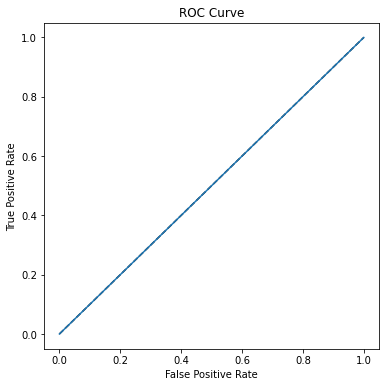

In [13]:
dummy = DummyClassifier(strategy = 'most_frequent')
score(dummy)

In [14]:
# Create a dataframe to keep track of feature importances
importances = pd.DataFrame(index=[X.columns])

### Decision Tree

Text(0.5, 1.0, 'Max Features')

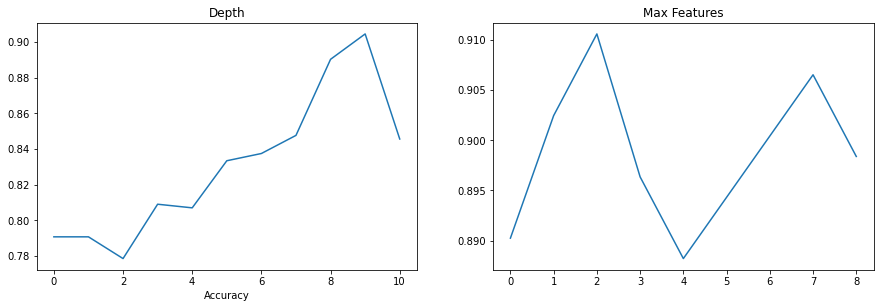

In [15]:
depth_scores = []
for depth in range(1,12):
    # Initialize and train our tree.
    decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=1,
        max_depth=depth,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )
    decision_tree.fit(X_train, y_train)
    depth_scores.append(decision_tree.score(X_test, y_test))
    
    
features_scores = [] 
for feature in range(1,10):
    # Initialize and train our tree.
    decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=feature,
        max_depth=9,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )
    decision_tree.fit(X_train, y_train)
    features_scores.append(decision_tree.score(X_test, y_test))
    
plt.figure(figsize=(15,10))    
plt.subplot(2,2,1)
plt.plot(depth_scores)
plt.title('Depth')
plt.xlabel('Accuracy')

plt.subplot(2,2,2)
plt.plot(features_scores)
plt.title('Max Features')
#print('Train score results: ', decision_tree.score(X_train, y_train), '\n', '=' * 22)
#print ('Test score results: ', decision_tree.score(X_test, y_test))

In [16]:
 decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=4,
        max_depth=10,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    350                 36
True Retired                         18                 88 

Accuracy Score: 0.8902439024390244
Recall Score: 0.8301886792452831
Precision Score: 0.7096774193548387
F-1 Score: 0.7652173913043478
Area under the ROC curve: 0.8768452439143612


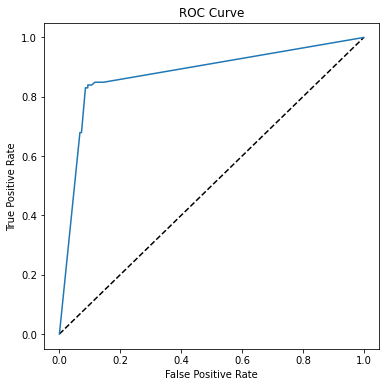

In [17]:
score(decision_tree)

In [18]:
# Get the feature importance
out =decision_tree.tree_.compute_feature_importances(normalize=False)

decision_tree_importances = pd.DataFrame(data=out
                                         , index=[X.columns], columns=['decision_tree'])

importances = importances.join(decision_tree_importances)

decision_tree_importances

,decision_tree
total_time,0.048290
mean_time,0.052441
trips,0.132902
total_distance,0.035347
mean_distance,0.093639
round_trip_rate,0.071800
trips_to_3000,0.000000
age,0.106123
use_rate,0.103783
avg_speed,0.046518


### Random Forest

In [19]:
rfc = ensemble.RandomForestClassifier(
    n_estimators=1000
    , max_features=4
    ,max_depth=10)

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    373                 13
True Retired                         22                 84 

Accuracy Score: 0.9288617886178862
Recall Score: 0.7924528301886793
Precision Score: 0.865979381443299
F-1 Score: 0.8275862068965517
Area under the ROC curve: 0.9801544628018379


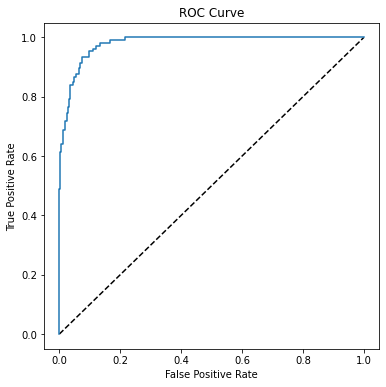

In [20]:
score(rfc)

In [21]:


out = rfc.feature_importances_
random_forest_importances = pd.DataFrame(data=out
                                         , index=[X.columns], columns=['random_forest'])
importances = importances.join(random_forest_importances)

random_forest_importances

,random_forest
total_time,0.058631
mean_time,0.065664
trips,0.077516
total_distance,0.084529
mean_distance,0.116282
round_trip_rate,0.113813
trips_to_3000,0.000000
age,0.218386
use_rate,0.120111
avg_speed,0.103540


### KNN

In [22]:
train_scores=[]
test_scores=[]
for val in np.arange(1,30):
    knn = neighbors.KNeighborsClassifier(n_neighbors=val)
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    train_scores.append(train_score)
    
    test_score= knn.score(X_test, y_test)
    test_scores.append(test_score)


In [23]:
weighted_train_scores=[]
weighted_test_scores=[]
for val in np.arange(1,30):
    knn = neighbors.KNeighborsClassifier(n_neighbors=val, weights='distance')
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    weighted_train_scores.append(train_score)
    
    test_score= knn.score(X_test, y_test)
    weighted_test_scores.append(test_score)


Text(0.5, 1.0, 'With Weighting')

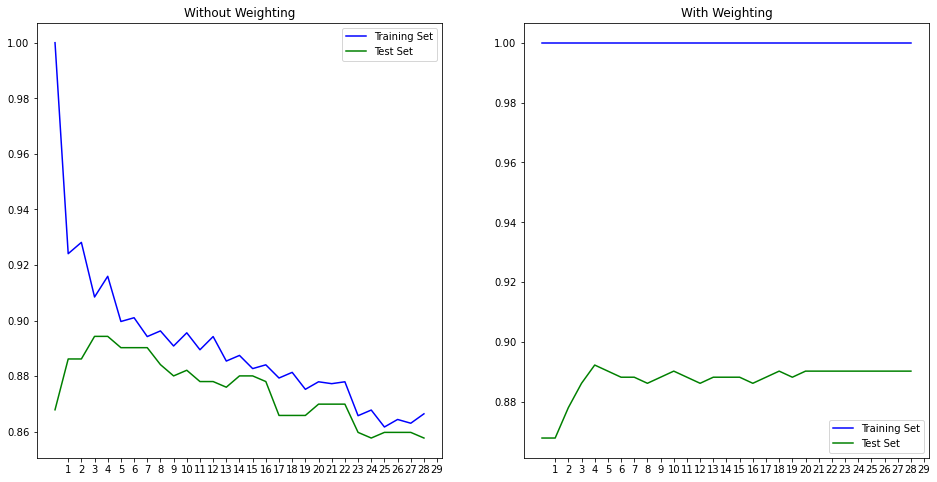

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(train_scores, color='blue', label='Training Set')
plt.plot(test_scores, color='green', label='Test Set')
plt.xticks(np.arange(1,30))
plt.legend()
plt.title('Without Weighting')


plt.subplot(1,2,2)
plt.plot(weighted_train_scores, color='blue', label='Training Set')
plt.plot(weighted_test_scores, color='green', label='Test Set')
plt.xticks(np.arange(1,30))
plt.legend()
plt.title('With Weighting')


-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    373                 13
True Retired                         46                 60 

Accuracy Score: 0.8800813008130082
Recall Score: 0.5660377358490566
Precision Score: 0.821917808219178
F-1 Score: 0.6703910614525139
Area under the ROC curve: 0.9147643953465636


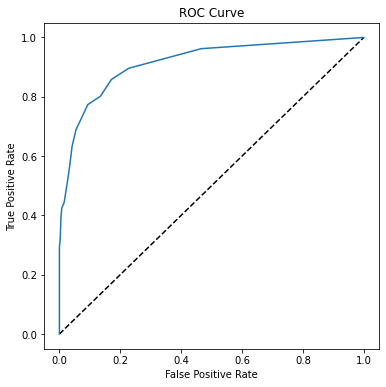

In [25]:
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
score(knn)

### Logistic Regression

In [26]:
lrc = LogisticRegression(solver='lbfgs') 

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    378                  8
True Retired                         87                 19 

Accuracy Score: 0.806910569105691
Recall Score: 0.1792452830188679
Precision Score: 0.7037037037037037
F-1 Score: 0.2857142857142857
Area under the ROC curve: 0.7296900967836544


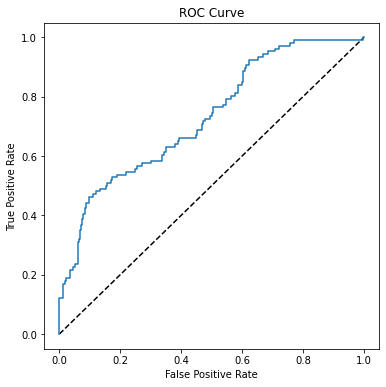

In [27]:
score(lrc)

### SVC

In [28]:
scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.25, random_state=1312)



-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    383                  3
True Retired                         69                 37 

Accuracy Score: 0.8536585365853658
Recall Score: 0.3490566037735849
Precision Score: 0.925
F-1 Score: 0.5068493150684931
Area under the ROC curve: 0.8551422426434646


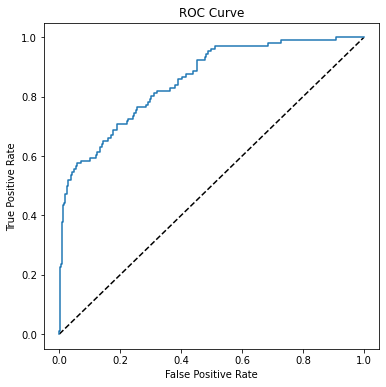

In [29]:
svc = SVC(kernel='linear', probability=True)
score(svc)

In [30]:
out = svc.coef_

pd.DataFrame(data=out.reshape(-1,1), index=[X.columns])

,0
total_time,0.542854
mean_time,-0.073009
trips,-4.154238
total_distance,3.116536
mean_distance,-0.405159
round_trip_rate,-0.247608
trips_to_3000,0.000000
age,-0.555307
use_rate,0.528053
avg_speed,0.532841


### AdaBoost

In [31]:
ada = ensemble.AdaBoostClassifier(
     n_estimators=1000
    , learning_rate=1.0)

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    376                 10
True Retired                         25                 81 

Accuracy Score: 0.9288617886178862
Recall Score: 0.7641509433962265
Precision Score: 0.8901098901098901
F-1 Score: 0.8223350253807108
Area under the ROC curve: 0.9614576204907616


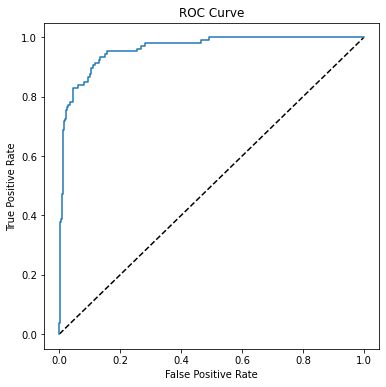

In [32]:
score(ada)

In [33]:
out = ada.feature_importances_

ada_feature_importances = pd.DataFrame(data=out, columns=['AdaBoost'], index=[X.columns])

importances = importances.join(ada_feature_importances)

ada_feature_importances.sort_values(by='AdaBoost')

,AdaBoost
trips_to_3000,0.000
electric,0.029
total_distance,0.065
round_trip_rate,0.065
trips,0.081
mean_distance,0.087
use_rate,0.088
mean_time,0.092
avg_speed,0.093
total_time,0.095


In [47]:
xgb = XGBClassifier(
    n_estimators=1000
    , learning_rate=1.0)

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    375                 11
True Retired                         18                 88 

Accuracy Score: 0.9410569105691057
Recall Score: 0.8301886792452831
Precision Score: 0.8888888888888888
F-1 Score: 0.8585365853658536
Area under the ROC curve: 0.9762195718056507


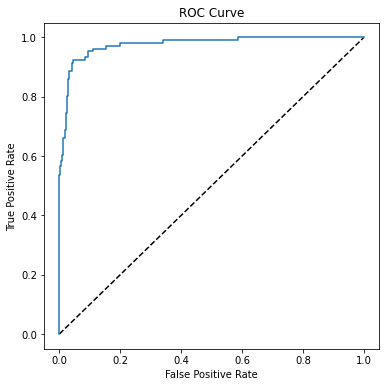

In [51]:
score(xgb)

In [36]:
out = xgb.feature_importances_

xgb_feature_importances = pd.DataFrame(data=out, columns =['XGBoost'], index=[X.columns])

importances = importances.join(xgb_feature_importances)

xgb_feature_importances.sort_values(by='XGBoost')

,XGBoost
trips_to_3000,0.000000
total_time,0.028027
mean_time,0.037519
avg_speed,0.063253
use_rate,0.065021
round_trip_rate,0.095620
trips,0.102652
total_distance,0.108963
electric,0.159471
age,0.166837


In [61]:
preds = xgb.predict(X_test)
confusion = confusion_matrix(y_test, preds, labels=[1, 0])

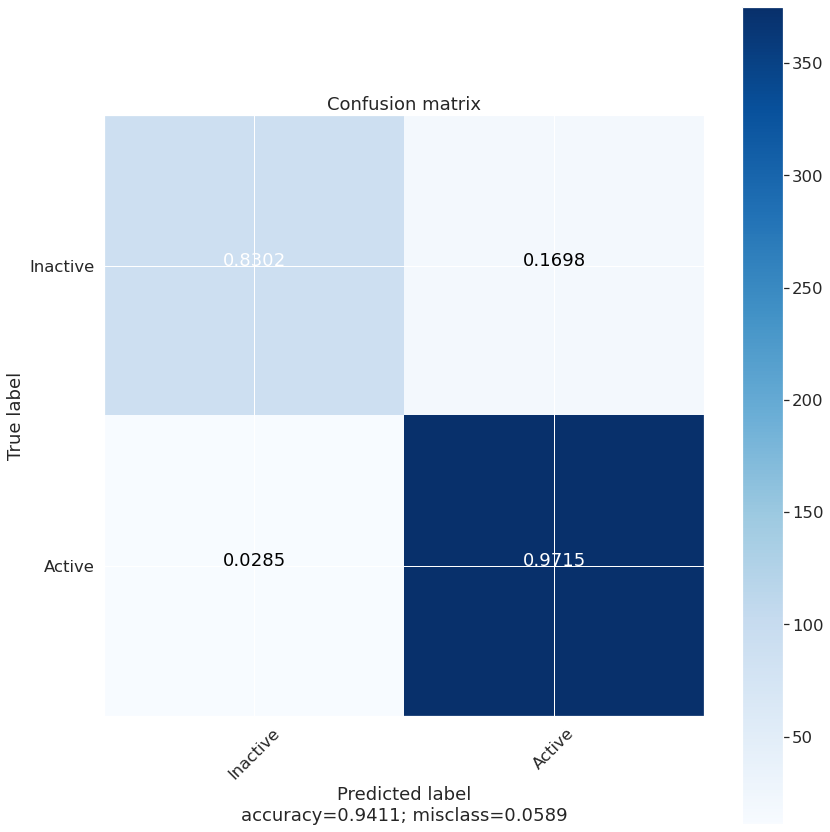

In [65]:
sns.set(font_scale=1.5)
plot_confusion_matrix(cm=confusion, target_names=['Inactive', 'Active'])

In [37]:
importances['sum'] = importances.sum(axis=1)
importances = importances.sort_values(by='sum', ascending=False)
importances.drop('sum', axis=1, inplace=True)

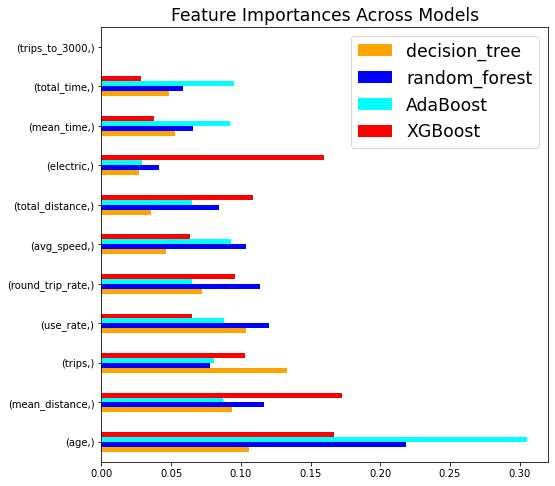

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
importances.plot(kind='barh', stacked=False, color=['orange', 'blue', 'cyan', 'red'], ax=ax)
plt.title('Feature Importances Across Models', size='xx-large')
# plt.xlim(0,1)
plt.legend(fontsize='xx-large')
plt.show()

In [39]:
# Use cross validation to confirm the three best solvers. AdaBoost, RandomForest, and XGBoost 
# all performed significantly better than the others and similarly to eachother.

solvers = {ada : 'AdaBoost Classifier' ,rfc : 'Random Forest Classifier',  xgb : 'XGBoost Classifier'}

for algo, name in solvers.items():
    scores = cross_val_score(algo, X_train, y_train, cv = 5)
    print('5 fold cross validation score mean for {}:  {}'.format(name, scores.mean()))

5 fold cross validation score mean for AdaBoost Classifier:  0.9227118644067795
5 fold cross validation score mean for Random Forest Classifier:  0.9206779661016948
5 fold cross validation score mean for XGBoost Classifier:  0.9308474576271186


## Conclusions and Discussion

The XGBoost Model performed best though similarly to other decision tree based models. Due to lack of linear separability along many of the features, linear models performed poorly as expected. This XGBoost could benefit further from more tuning, and according to the business case be modified for high precision or recall.


This model significantly outperforms a baseline model but can still be improved significantly. In addition this project would benefit from better data, which is likely available internally to the company. Aggregation and some careful assumptions lead to this output. Based upon the success of the model under these challenging circumstances it represents strong proof of concept that this model or one similar to it could produce valuable insights for Inedgo.